In [1]:
from z3 import *
import numpy as np
import re
import arviz as az

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `spur` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Maja's model

# Assumption, all bit-vectors are of the same size
num_bits = 8
num_vars = 5
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4]])) # important
g.add(x[2] == 30)
g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5)
g.add(ULE(x[0],30)) # ULE is <= (using simply <= does not work)
g.add(ULE(x[1],30))
g.add(ULE(30,x[3]))
g.add(ULE(30,x[4]))
g.add(ULE(x[3],125))
g.add(ULE(x[4],125))

As a sanity check, we verify that the SMTproblem has a solution

In [3]:
# sanity check (optional)
solve(g)

[x34 = False,
 x46 = False,
 x10 = False,
 x04 = False,
 x32 = True,
 x03 = True,
 x41 = True,
 x44 = True,
 x01 = False,
 x06 = False,
 x33 = True,
 x35 = False,
 x42 = False,
 x36 = True,
 x45 = True,
 x11 = True,
 x12 = False,
 x02 = True,
 x40 = True,
 x13 = False,
 x43 = False,
 x31 = True,
 x30 = True,
 x14 = True,
 x16 = False,
 x17 = False,
 x15 = False,
 x05 = False,
 x07 = False,
 x00 = False,
 x3 = 79,
 x1 = 18,
 x4 = 51,
 x0 = 12,
 x27 = False,
 x23 = True,
 x24 = True,
 x47 = False,
 x21 = True,
 x22 = True,
 x37 = False,
 x26 = False,
 x25 = False,
 x2 = 30,
 x20 = False]


## Bit-blasting

The function below bit-blasts the problem and stores it in CNF form in the specified directory and file. The bit-blasted problem is stored in DIMACS format. This is one for the input formats that `spur` supports.

The `save_dimacs` function returns a pair with two elements. 

The first one is that number of variables in the bit-blasted problem (`num_variables`)---do not confuse this variable with `num_vars`, which is the number of variables in the original SMT problem. The resulting bit-blasted problem is a SAT problem.

The second element `variables_number` is a map `int -> Z3_VAR` that assigs a natural number to each bit-blasted variable. This map is necessary to reverse the bit-blasting process after obtaining the samples from `spur`.

In [5]:
input_dir = 'spur_input'
input_file = 'Database1.cnf'
(num_variables, variables_number) = sat.save_dimacs(g, 
                                                    f'{input_dir}/{input_file}')

Here we call `spur` using the input file created in the previous step. We instruct it to generate 10000 samples. The output samples are stored in the same directory as the input file, and the output file is named `samples_<input_file>.txt`.

In [13]:
num_samples   = 10000
sat.execute_spur(f'{input_dir}/{input_file}',num_samples=num_samples)

Using default filename: "spur_input/samples_Database1.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/Database1.cnf
Output File: spur_input/samples_Database1.txt

Preprocessing ... DONE
variables (all/used/free): 	327/327/0
independent support size:  	0
clauses (all/long/binary/unit): 1333/981/332/20
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	3114 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	3114 MB

Sample #1 of 3696 is already a complete assignment.  Continuing...
Completing sample #2 of 3696 which has 13 variables unset and 7 samples.
Completing sample #3 of 3696 which has 26 variables unset and 3 samples.
Completing sample #4 of 3696 which has 13 variables unset and 6 samples.
Completing sample #5 of 3696 which has 85 variables unset and 3 samples.
Completing sample #6 of 3696 which has 27 variables unset and 1 sample.
Completing sample #7 of 3696 which has 39 variables unset and 1 sample.
Completing sample #8 of 3696 which has 39 variables unset and 1 sample.
Completing sample #9 of 3696 which has 52 variables unset and 4 samples.
Completing sample #10 of 3696 which has 100 variables unset and 2 samples.
Completing sample #11 of 3696 which has 59 variables unset and 1 sample.
Co

Completing sample #117 of 3696 which has 33 variables unset and 1 sample.
Completing sample #118 of 3696 which has 23 variables unset and 1 sample.
Completing sample #119 of 3696 which has 58 variables unset and 3 samples.
Completing sample #120 of 3696 which has 30 variables unset and 1 sample.
Completing sample #121 of 3696 which has 75 variables unset and 2 samples.
Completing sample #122 of 3696 which has 16 variables unset and 18 samples.
Completing sample #123 of 3696 which has 45 variables unset and 2 samples.
Completing sample #124 of 3696 which has 45 variables unset and 1 sample.
Completing sample #125 of 3696 which has 58 variables unset and 1 sample.
Completing sample #126 of 3696 which has 30 variables unset and 6 samples.
Completing sample #127 of 3696 which has 10 variables unset and 12 samples.
Completing sample #128 of 3696 which has 17 variables unset and 14 samples.
Completing sample #129 of 3696 which has 53 variables unset and 1 sample.
Completing sample #130 of 36

Completing sample #267 of 3696 which has 66 variables unset and 1 sample.
Completing sample #268 of 3696 which has 22 variables unset and 3 samples.
Completing sample #269 of 3696 which has 20 variables unset and 1 sample.
Completing sample #270 of 3696 which has 68 variables unset and 1 sample.
Completing sample #271 of 3696 which has 16 variables unset and 9 samples.
Completing sample #272 of 3696 which has 24 variables unset and 2 samples.
Completing sample #273 of 3696 which has 59 variables unset and 5 samples.
Completing sample #274 of 3696 which has 38 variables unset and 2 samples.
Completing sample #275 of 3696 which has 36 variables unset and 16 samples.
Completing sample #276 of 3696 which has 61 variables unset and 2 samples.
Completing sample #277 of 3696 which has 13 variables unset and 1 sample.
Completing sample #278 of 3696 which has 63 variables unset and 2 samples.
Completing sample #279 of 3696 which has 38 variables unset and 1 sample.
Completing sample #280 of 369

Completing sample #412 of 3696 which has 44 variables unset and 1 sample.
Completing sample #413 of 3696 which has 73 variables unset and 2 samples.
Completing sample #414 of 3696 which has 92 variables unset and 3 samples.
Completing sample #415 of 3696 which has 73 variables unset and 3 samples.
Completing sample #416 of 3696 which has 90 variables unset and 5 samples.
Completing sample #417 of 3696 which has 82 variables unset and 2 samples.
Completing sample #418 of 3696 which has 90 variables unset and 3 samples.
Completing sample #419 of 3696 which has 80 variables unset and 3 samples.
Completing sample #420 of 3696 which has 88 variables unset and 1 sample.
Completing sample #421 of 3696 which has 95 variables unset and 2 samples.
Completing sample #422 of 3696 which has 78 variables unset and 2 samples.
Completing sample #423 of 3696 which has 76 variables unset and 2 samples.
Completing sample #424 of 3696 which has 97 variables unset and 11 samples.
Completing sample #425 of 

Completing sample #536 of 3696 which has 94 variables unset and 1 sample.
Completing sample #537 of 3696 which has 65 variables unset and 3 samples.
Completing sample #538 of 3696 which has 39 variables unset and 2 samples.
Completing sample #539 of 3696 which has 72 variables unset and 3 samples.
Completing sample #540 of 3696 which has 28 variables unset and 2 samples.
Completing sample #541 of 3696 which has 71 variables unset and 2 samples.
Completing sample #542 of 3696 which has 53 variables unset and 1 sample.
Completing sample #543 of 3696 which has 54 variables unset and 1 sample.
Completing sample #544 of 3696 which has 63 variables unset and 2 samples.
Completing sample #545 of 3696 which has 46 variables unset and 2 samples.
Completing sample #546 of 3696 which has 31 variables unset and 2 samples.
Completing sample #547 of 3696 which has 29 variables unset and 2 samples.
Completing sample #548 of 3696 which has 40 variables unset and 2 samples.
Completing sample #549 of 36

Completing sample #679 of 3696 which has 62 variables unset and 2 samples.
Completing sample #680 of 3696 which has 48 variables unset and 3 samples.
Completing sample #681 of 3696 which has 51 variables unset and 1 sample.
Completing sample #682 of 3696 which has 90 variables unset and 1 sample.
Completing sample #683 of 3696 which has 62 variables unset and 1 sample.
Completing sample #684 of 3696 which has 79 variables unset and 7 samples.
Completing sample #685 of 3696 which has 57 variables unset and 1 sample.
Completing sample #686 of 3696 which has 92 variables unset and 1 sample.
Completing sample #687 of 3696 which has 56 variables unset and 17 samples.
Completing sample #688 of 3696 which has 54 variables unset and 1 sample.
Completing sample #689 of 3696 which has 89 variables unset and 2 samples.
Completing sample #690 of 3696 which has 61 variables unset and 1 sample.
Completing sample #691 of 3696 which has 34 variables unset and 1 sample.
Completing sample #692 of 3696 w

Completing sample #817 of 3696 which has 95 variables unset and 2 samples.
Completing sample #818 of 3696 which has 101 variables unset and 4 samples.
Completing sample #819 of 3696 which has 96 variables unset and 3 samples.
Completing sample #820 of 3696 which has 102 variables unset and 2 samples.
Completing sample #821 of 3696 which has 89 variables unset and 3 samples.
Completing sample #822 of 3696 which has 95 variables unset and 2 samples.
Completing sample #823 of 3696 which has 96 variables unset and 3 samples.
Completing sample #824 of 3696 which has 57 variables unset and 1 sample.
Completing sample #825 of 3696 which has 25 variables unset and 3 samples.
Completing sample #826 of 3696 which has 40 variables unset and 2 samples.
Completing sample #827 of 3696 which has 40 variables unset and 1 sample.
Completing sample #828 of 3696 which has 40 variables unset and 1 sample.
Completing sample #829 of 3696 which has 57 variables unset and 1 sample.
Completing sample #830 of 3

Completing sample #955 of 3696 which has 62 variables unset and 1 sample.
Completing sample #956 of 3696 which has 55 variables unset and 5 samples.
Completing sample #957 of 3696 which has 79 variables unset and 4 samples.
Completing sample #958 of 3696 which has 83 variables unset and 1 sample.
Completing sample #959 of 3696 which has 94 variables unset and 2 samples.
Completing sample #960 of 3696 which has 87 variables unset and 5 samples.
Completing sample #961 of 3696 which has 69 variables unset and 1 sample.
Completing sample #962 of 3696 which has 68 variables unset and 3 samples.
Completing sample #963 of 3696 which has 75 variables unset and 1 sample.
Completing sample #964 of 3696 which has 66 variables unset and 2 samples.
Completing sample #965 of 3696 which has 66 variables unset and 5 samples.
Completing sample #966 of 3696 which has 93 variables unset and 5 samples.
Completing sample #967 of 3696 which has 91 variables unset and 5 samples.
Completing sample #968 of 369

Completing sample #1079 of 3696 which has 56 variables unset and 2 samples.
Completing sample #1080 of 3696 which has 82 variables unset and 2 samples.
Completing sample #1081 of 3696 which has 33 variables unset and 1 sample.
Completing sample #1082 of 3696 which has 83 variables unset and 2 samples.
Completing sample #1083 of 3696 which has 57 variables unset and 1 sample.
Completing sample #1084 of 3696 which has 54 variables unset and 1 sample.
Completing sample #1085 of 3696 which has 64 variables unset and 3 samples.
Completing sample #1086 of 3696 which has 14 variables unset and 2 samples.
Completing sample #1087 of 3696 which has 79 variables unset and 3 samples.
Completing sample #1088 of 3696 which has 13 variables unset and 6 samples.
Completing sample #1089 of 3696 which has 57 variables unset and 1 sample.
Completing sample #1090 of 3696 which has 24 variables unset and 2 samples.
Completing sample #1091 of 3696 which has 29 variables unset and 1 sample.
Completing sample

Completing sample #1226 of 3696 which has 32 variables unset and 1 sample.
Completing sample #1227 of 3696 which has 15 variables unset and 14 samples.
Completing sample #1228 of 3696 which has 67 variables unset and 2 samples.
Completing sample #1229 of 3696 which has 52 variables unset and 1 sample.
Completing sample #1230 of 3696 which has 53 variables unset and 1 sample.
Completing sample #1231 of 3696 which has 38 variables unset and 4 samples.
Completing sample #1232 of 3696 which has 52 variables unset and 2 samples.
Completing sample #1233 of 3696 which has 52 variables unset and 1 sample.
Completing sample #1234 of 3696 which has 38 variables unset and 1 sample.
Completing sample #1235 of 3696 which has 68 variables unset and 3 samples.
Completing sample #1236 of 3696 which has 68 variables unset and 1 sample.
Completing sample #1237 of 3696 which has 56 variables unset and 9 samples.
Completing sample #1238 of 3696 which has 88 variables unset and 8 samples.
Completing sample

Completing sample #1353 of 3696 which has 70 variables unset and 1 sample.
Completing sample #1354 of 3696 which has 78 variables unset and 3 samples.
Completing sample #1355 of 3696 which has 56 variables unset and 6 samples.
Completing sample #1356 of 3696 which has 77 variables unset and 2 samples.
Completing sample #1357 of 3696 which has 86 variables unset and 2 samples.
Completing sample #1358 of 3696 which has 51 variables unset and 1 sample.
Completing sample #1359 of 3696 which has 45 variables unset and 1 sample.
Completing sample #1360 of 3696 which has 79 variables unset and 2 samples.
Completing sample #1361 of 3696 which has 85 variables unset and 1 sample.
Completing sample #1362 of 3696 which has 35 variables unset and 1 sample.
Completing sample #1363 of 3696 which has 38 variables unset and 6 samples.
Completing sample #1364 of 3696 which has 68 variables unset and 2 samples.
Completing sample #1365 of 3696 which has 85 variables unset and 1 sample.
Completing sample 

Completing sample #1483 of 3696 which has 65 variables unset and 1 sample.
Completing sample #1484 of 3696 which has 60 variables unset and 2 samples.
Completing sample #1485 of 3696 which has 72 variables unset and 2 samples.
Completing sample #1486 of 3696 which has 65 variables unset and 1 sample.
Completing sample #1487 of 3696 which has 83 variables unset and 1 sample.
Completing sample #1488 of 3696 which has 57 variables unset and 3 samples.
Completing sample #1489 of 3696 which has 52 variables unset and 3 samples.
Completing sample #1490 of 3696 which has 93 variables unset and 2 samples.
Completing sample #1491 of 3696 which has 47 variables unset and 4 samples.
Completing sample #1492 of 3696 which has 38 variables unset and 1 sample.
Completing sample #1493 of 3696 which has 53 variables unset and 1 sample.
Completing sample #1494 of 3696 which has 85 variables unset and 6 samples.
Completing sample #1495 of 3696 which has 53 variables unset and 1 sample.
Completing sample 

Completing sample #1607 of 3696 which has 76 variables unset and 2 samples.
Completing sample #1608 of 3696 which has 72 variables unset and 5 samples.
Completing sample #1609 of 3696 which has 116 variables unset and 10 samples.
Completing sample #1610 of 3696 which has 70 variables unset and 1 sample.
Completing sample #1611 of 3696 which has 36 variables unset and 1 sample.
Completing sample #1612 of 3696 which has 84 variables unset and 2 samples.
Completing sample #1613 of 3696 which has 61 variables unset and 1 sample.
Completing sample #1614 of 3696 which has 73 variables unset and 1 sample.
Completing sample #1615 of 3696 which has 70 variables unset and 3 samples.
Completing sample #1616 of 3696 which has 38 variables unset and 3 samples.
Completing sample #1617 of 3696 which has 73 variables unset and 2 samples.
Completing sample #1618 of 3696 which has 66 variables unset and 2 samples.
Completing sample #1619 of 3696 which has 52 variables unset and 1 sample.
Completing samp

Completing sample #1726 of 3696 which has 40 variables unset and 1 sample.
Completing sample #1727 of 3696 which has 56 variables unset and 1 sample.
Completing sample #1728 of 3696 which has 12 variables unset and 1 sample.
Completing sample #1729 of 3696 which has 52 variables unset and 1 sample.
Completing sample #1730 of 3696 which has 41 variables unset and 2 samples.
Completing sample #1731 of 3696 which has 14 variables unset and 1 sample.
Completing sample #1732 of 3696 which has 72 variables unset and 1 sample.
Completing sample #1733 of 3696 which has 74 variables unset and 4 samples.
Completing sample #1734 of 3696 which has 61 variables unset and 2 samples.
Completing sample #1735 of 3696 which has 59 variables unset and 3 samples.
Completing sample #1736 of 3696 which has 80 variables unset and 1 sample.
Completing sample #1737 of 3696 which has 79 variables unset and 2 samples.
Completing sample #1738 of 3696 which has 91 variables unset and 4 samples.
Completing sample #

Completing sample #1859 of 3696 which has 28 variables unset and 1 sample.
Completing sample #1860 of 3696 which has 54 variables unset and 1 sample.
Completing sample #1861 of 3696 which has 30 variables unset and 2 samples.
Completing sample #1862 of 3696 which has 19 variables unset and 1 sample.
Completing sample #1863 of 3696 which has 32 variables unset and 1 sample.
Completing sample #1864 of 3696 which has 30 variables unset and 1 sample.
Completing sample #1865 of 3696 which has 51 variables unset and 1 sample.
Completing sample #1866 of 3696 which has 56 variables unset and 2 samples.
Completing sample #1867 of 3696 which has 34 variables unset and 2 samples.
Completing sample #1868 of 3696 which has 63 variables unset and 2 samples.
Completing sample #1869 of 3696 which has 37 variables unset and 1 sample.
Completing sample #1870 of 3696 which has 44 variables unset and 1 sample.
Completing sample #1871 of 3696 which has 30 variables unset and 2 samples.
Completing sample #1

Completing sample #1986 of 3696 which has 37 variables unset and 2 samples.
Completing sample #1987 of 3696 which has 30 variables unset and 1 sample.
Completing sample #1988 of 3696 which has 68 variables unset and 5 samples.
Completing sample #1989 of 3696 which has 13 variables unset and 8 samples.
Completing sample #1990 of 3696 which has 75 variables unset and 5 samples.
Completing sample #1991 of 3696 which has 62 variables unset and 6 samples.
Completing sample #1992 of 3696 which has 34 variables unset and 1 sample.
Completing sample #1993 of 3696 which has 25 variables unset and 3 samples.
Completing sample #1994 of 3696 which has 60 variables unset and 17 samples.
Completing sample #1995 of 3696 which has 73 variables unset and 3 samples.
Completing sample #1996 of 3696 which has 72 variables unset and 3 samples.
Completing sample #1997 of 3696 which has 34 variables unset and 2 samples.
Completing sample #1998 of 3696 which has 26 variables unset and 5 samples.
Completing sa

Completing sample #2124 of 3696 which has 34 variables unset and 2 samples.
Completing sample #2125 of 3696 which has 49 variables unset and 3 samples.
Completing sample #2126 of 3696 which has 49 variables unset and 2 samples.
Completing sample #2127 of 3696 which has 38 variables unset and 2 samples.
Completing sample #2128 of 3696 which has 74 variables unset and 7 samples.
Completing sample #2129 of 3696 which has 74 variables unset and 7 samples.
Completing sample #2130 of 3696 which has 61 variables unset and 6 samples.
Completing sample #2131 of 3696 which has 60 variables unset and 2 samples.
Completing sample #2132 of 3696 which has 70 variables unset and 3 samples.
Completing sample #2133 of 3696 which has 64 variables unset and 1 sample.
Completing sample #2134 of 3696 which has 62 variables unset and 1 sample.
Completing sample #2135 of 3696 which has 62 variables unset and 2 samples.
Completing sample #2136 of 3696 which has 53 variables unset and 4 samples.
Completing sam

Completing sample #2254 of 3696 which has 23 variables unset and 1 sample.
Completing sample #2255 of 3696 which has 67 variables unset and 2 samples.
Completing sample #2256 of 3696 which has 32 variables unset and 4 samples.
Completing sample #2257 of 3696 which has 59 variables unset and 1 sample.
Completing sample #2258 of 3696 which has 59 variables unset and 3 samples.
Completing sample #2259 of 3696 which has 76 variables unset and 3 samples.
Completing sample #2260 of 3696 which has 83 variables unset and 2 samples.
Completing sample #2261 of 3696 which has 82 variables unset and 1 sample.
Completing sample #2262 of 3696 which has 96 variables unset and 7 samples.
Completing sample #2263 of 3696 which has 61 variables unset and 4 samples.
Completing sample #2264 of 3696 which has 64 variables unset and 3 samples.
Completing sample #2265 of 3696 which has 36 variables unset and 6 samples.
Completing sample #2266 of 3696 which has 67 variables unset and 1 sample.
Completing sampl

Completing sample #2369 of 3696 which has 43 variables unset and 3 samples.
Completing sample #2370 of 3696 which has 30 variables unset and 1 sample.
Completing sample #2371 of 3696 which has 95 variables unset and 7 samples.
Completing sample #2372 of 3696 which has 59 variables unset and 1 sample.
Completing sample #2373 of 3696 which has 45 variables unset and 1 sample.
Completing sample #2374 of 3696 which has 57 variables unset and 1 sample.
Completing sample #2375 of 3696 which has 75 variables unset and 2 samples.
Completing sample #2376 of 3696 which has 95 variables unset and 2 samples.
Completing sample #2377 of 3696 which has 59 variables unset and 7 samples.
Completing sample #2378 of 3696 which has 87 variables unset and 3 samples.
Completing sample #2379 of 3696 which has 40 variables unset and 1 sample.
Completing sample #2380 of 3696 which has 92 variables unset and 3 samples.
Completing sample #2381 of 3696 which has 51 variables unset and 2 samples.
Completing sample

Completing sample #2492 of 3696 which has 47 variables unset and 1 sample.
Completing sample #2493 of 3696 which has 65 variables unset and 1 sample.
Completing sample #2494 of 3696 which has 49 variables unset and 1 sample.
Completing sample #2495 of 3696 which has 37 variables unset and 1 sample.
Completing sample #2496 of 3696 which has 69 variables unset and 1 sample.
Completing sample #2497 of 3696 which has 54 variables unset and 4 samples.
Completing sample #2498 of 3696 which has 44 variables unset and 2 samples.
Completing sample #2499 of 3696 which has 14 variables unset and 1 sample.
Completing sample #2500 of 3696 which has 45 variables unset and 2 samples.
Completing sample #2501 of 3696 which has 60 variables unset and 3 samples.
Completing sample #2502 of 3696 which has 63 variables unset and 1 sample.
Completing sample #2503 of 3696 which has 56 variables unset and 1 sample.
Completing sample #2504 of 3696 which has 66 variables unset and 3 samples.
Completing sample #2

Completing sample #2613 of 3696 which has 91 variables unset and 5 samples.
Completing sample #2614 of 3696 which has 71 variables unset and 4 samples.
Completing sample #2615 of 3696 which has 43 variables unset and 2 samples.
Completing sample #2616 of 3696 which has 54 variables unset and 1 sample.
Completing sample #2617 of 3696 which has 41 variables unset and 2 samples.
Completing sample #2618 of 3696 which has 41 variables unset and 1 sample.
Completing sample #2619 of 3696 which has 54 variables unset and 1 sample.
Completing sample #2620 of 3696 which has 36 variables unset and 2 samples.
Completing sample #2621 of 3696 which has 23 variables unset and 2 samples.
Completing sample #2622 of 3696 which has 34 variables unset and 3 samples.
Completing sample #2623 of 3696 which has 21 variables unset and 2 samples.
Completing sample #2624 of 3696 which has 36 variables unset and 5 samples.
Completing sample #2625 of 3696 which has 59 variables unset and 3 samples.
Completing samp

Completing sample #2752 of 3696 which has 23 variables unset and 2 samples.
Completing sample #2753 of 3696 which has 48 variables unset and 2 samples.
Completing sample #2754 of 3696 which has 51 variables unset and 2 samples.
Completing sample #2755 of 3696 which has 33 variables unset and 1 sample.
Completing sample #2756 of 3696 which has 46 variables unset and 1 sample.
Completing sample #2757 of 3696 which has 38 variables unset and 2 samples.
Completing sample #2758 of 3696 which has 31 variables unset and 1 sample.
Completing sample #2759 of 3696 which has 46 variables unset and 1 sample.
Completing sample #2760 of 3696 which has 31 variables unset and 1 sample.
Completing sample #2761 of 3696 which has 82 variables unset and 2 samples.
Completing sample #2762 of 3696 which has 42 variables unset and 2 samples.
Completing sample #2763 of 3696 which has 48 variables unset and 1 sample.
Completing sample #2764 of 3696 which has 35 variables unset and 1 sample.
Completing sample #

Completing sample #2877 of 3696 which has 60 variables unset and 3 samples.
Completing sample #2878 of 3696 which has 81 variables unset and 3 samples.
Completing sample #2879 of 3696 which has 77 variables unset and 2 samples.
Completing sample #2880 of 3696 which has 104 variables unset and 4 samples.
Completing sample #2881 of 3696 which has 49 variables unset and 1 sample.
Completing sample #2882 of 3696 which has 59 variables unset and 1 sample.
Completing sample #2883 of 3696 which has 56 variables unset and 1 sample.
Completing sample #2884 of 3696 which has 57 variables unset and 1 sample.
Completing sample #2885 of 3696 which has 57 variables unset and 1 sample.
Completing sample #2886 of 3696 which has 51 variables unset and 1 sample.
Completing sample #2887 of 3696 which has 89 variables unset and 4 samples.
Completing sample #2888 of 3696 which has 115 variables unset and 1 sample.
Completing sample #2889 of 3696 which has 70 variables unset and 2 samples.
Completing sample

Completing sample #2992 of 3696 which has 89 variables unset and 1 sample.
Completing sample #2993 of 3696 which has 90 variables unset and 3 samples.
Completing sample #2994 of 3696 which has 98 variables unset and 3 samples.
Completing sample #2995 of 3696 which has 66 variables unset and 2 samples.
Completing sample #2996 of 3696 which has 82 variables unset and 2 samples.
Completing sample #2997 of 3696 which has 89 variables unset and 2 samples.
Completing sample #2998 of 3696 which has 89 variables unset and 3 samples.
Completing sample #2999 of 3696 which has 87 variables unset and 2 samples.
Completing sample #3000 of 3696 which has 108 variables unset and 2 samples.
Completing sample #3001 of 3696 which has 88 variables unset and 2 samples.
Completing sample #3002 of 3696 which has 71 variables unset and 1 sample.
Completing sample #3003 of 3696 which has 108 variables unset and 1 sample.
Completing sample #3004 of 3696 which has 66 variables unset and 1 sample.
Completing sam

Completing sample #3111 of 3696 which has 75 variables unset and 2 samples.
Completing sample #3112 of 3696 which has 98 variables unset and 3 samples.
Completing sample #3113 of 3696 which has 75 variables unset and 2 samples.
Completing sample #3114 of 3696 which has 102 variables unset and 4 samples.
Completing sample #3115 of 3696 which has 72 variables unset and 2 samples.
Completing sample #3116 of 3696 which has 73 variables unset and 2 samples.
Completing sample #3117 of 3696 which has 49 variables unset and 1 sample.
Completing sample #3118 of 3696 which has 29 variables unset and 1 sample.
Completing sample #3119 of 3696 which has 69 variables unset and 2 samples.
Completing sample #3120 of 3696 which has 29 variables unset and 1 sample.
Completing sample #3121 of 3696 which has 68 variables unset and 1 sample.
Completing sample #3122 of 3696 which has 40 variables unset and 5 samples.
Completing sample #3123 of 3696 which has 68 variables unset and 4 samples.
Completing samp

Completing sample #3210 of 3696 which has 85 variables unset and 5 samples.
Completing sample #3211 of 3696 which has 52 variables unset and 6 samples.
Completing sample #3212 of 3696 which has 60 variables unset and 5 samples.
Completing sample #3213 of 3696 which has 53 variables unset and 3 samples.
Completing sample #3214 of 3696 which has 76 variables unset and 9 samples.
Completing sample #3215 of 3696 which has 112 variables unset and 7 samples.
Completing sample #3216 of 3696 which has 72 variables unset and 3 samples.
Completing sample #3217 of 3696 which has 78 variables unset and 5 samples.
Completing sample #3218 of 3696 which has 52 variables unset and 1 sample.
Completing sample #3219 of 3696 which has 32 variables unset and 2 samples.
Completing sample #3220 of 3696 which has 44 variables unset and 2 samples.
Completing sample #3221 of 3696 which has 47 variables unset and 1 sample.
Completing sample #3222 of 3696 which has 77 variables unset and 4 samples.
Completing sa

Completing sample #3319 of 3696 which has 29 variables unset and 2 samples.
Completing sample #3320 of 3696 which has 44 variables unset and 2 samples.
Completing sample #3321 of 3696 which has 45 variables unset and 1 sample.
Completing sample #3322 of 3696 which has 78 variables unset and 1 sample.
Completing sample #3323 of 3696 which has 76 variables unset and 1 sample.
Completing sample #3324 of 3696 which has 47 variables unset and 1 sample.
Completing sample #3325 of 3696 which has 78 variables unset and 2 samples.
Completing sample #3326 of 3696 which has 71 variables unset and 4 samples.
Completing sample #3327 of 3696 which has 43 variables unset and 1 sample.
Completing sample #3328 of 3696 which has 78 variables unset and 4 samples.
Completing sample #3329 of 3696 which has 88 variables unset and 11 samples.
Completing sample #3330 of 3696 which has 44 variables unset and 1 sample.
Completing sample #3331 of 3696 which has 59 variables unset and 4 samples.
Completing sample

Completing sample #3447 of 3696 which has 42 variables unset and 2 samples.
Completing sample #3448 of 3696 which has 63 variables unset and 1 sample.
Completing sample #3449 of 3696 which has 59 variables unset and 1 sample.
Completing sample #3450 of 3696 which has 56 variables unset and 1 sample.
Completing sample #3451 of 3696 which has 61 variables unset and 1 sample.
Completing sample #3452 of 3696 which has 57 variables unset and 1 sample.
Completing sample #3453 of 3696 which has 86 variables unset and 3 samples.
Completing sample #3454 of 3696 which has 34 variables unset and 4 samples.
Completing sample #3455 of 3696 which has 28 variables unset and 2 samples.
Completing sample #3456 of 3696 which has 83 variables unset and 1 sample.
Completing sample #3457 of 3696 which has 13 variables unset and 1 sample.
Completing sample #3458 of 3696 which has 21 variables unset and 3 samples.
Completing sample #3459 of 3696 which has 35 variables unset and 1 sample.
Completing sample #3

Completing sample #3576 of 3696 which has 104 variables unset and 1 sample.
Completing sample #3577 of 3696 which has 53 variables unset and 1 sample.
Completing sample #3578 of 3696 which has 104 variables unset and 6 samples.
Completing sample #3579 of 3696 which has 74 variables unset and 2 samples.
Completing sample #3580 of 3696 which has 63 variables unset and 3 samples.
Completing sample #3581 of 3696 which has 103 variables unset and 5 samples.
Completing sample #3582 of 3696 which has 63 variables unset and 1 sample.
Completing sample #3583 of 3696 which has 88 variables unset and 8 samples.
Completing sample #3584 of 3696 which has 89 variables unset and 2 samples.
Completing sample #3585 of 3696 which has 89 variables unset and 7 samples.
Completing sample #3586 of 3696 which has 88 variables unset and 5 samples.
Completing sample #3587 of 3696 which has 88 variables unset and 3 samples.
Completing sample #3588 of 3696 which has 53 variables unset and 1 sample.
Completing sa

e,2.75385
pass2_time,5.8354
#END_HEADER


The function below parses the samples generated by `spur`. It returns a matrix with coordinates (sample, bit-blasted_var) containing all generated samples. That is, each row correspond a sample, and each column contains the value of a bit-blasted variable.

For now, the function takes as input the input directory and file for `spur`. That is, the same parameters as the previous function. The function below automatically infers the name of file containing the samples generated by `spur`.

In [14]:
samples = sat.parse_spur_samples(input_dir, input_file, 
                                 num_samples, num_variables)

The function below performs an intermediate step where we create a map from z3 bit-blasted variables to their sampled values, i.e., Z3_VAR -> list[bool].

In [15]:
map_variable_values = sat.map_spur_samples_to_z3_vars(variables_number, 
                                                      num_variables,
                                                      samples)

## Reverse bit-blasting

Finally, we take the map above to reverse the bit-blasting process for each of the spur samples. The function below returns a list of dictionaries. Each dictionary contains a sample value for the SMT problem variables (i.e., reverse-bit-blasted variables). This output format is expected output for our `mcmc.sample_mh_trace` function.

The function below takes as input the map from Z3 bit-blasted variables to values, the number of generated samples, the number of varibles (**in the SMT problem**), and the number of bits of the bit-vectors of the SMT problem. We emphasize again that the number of variables in this function refers to the number of bit-vectors in the SMT problem. Do not confuse with the number of variables in the bit-blasted SAT problem.

Here we note an important requirement of this process. All bit-vectors must have the same number of bits.

In [16]:
solver_samples = sat.reverse_bit_blasting(map_variable_values, 
                                          num_samples,
                                          num_vars,
                                          num_bits)

As a sanity check, we have created a function that checks that all generated samples satisfy the SMT problem. 

This is an optional step. Be careful when executed for a large number of samples, as it is a computationally expensive process.

In [17]:
#  sanity check (optional, heavy computation)
utils.sat_checking_samples(g, solver_samples[:10], var_list)

True

At this point, we can use the `solver_samples` to execute our Metropolis-Hastings algorithm.

We remark that the funciton call before is exactly the same as when we use Megasampler for generating samples.

In [18]:
trace = mcmc.sample_mh_trace(num_samples, 4, solver_samples)

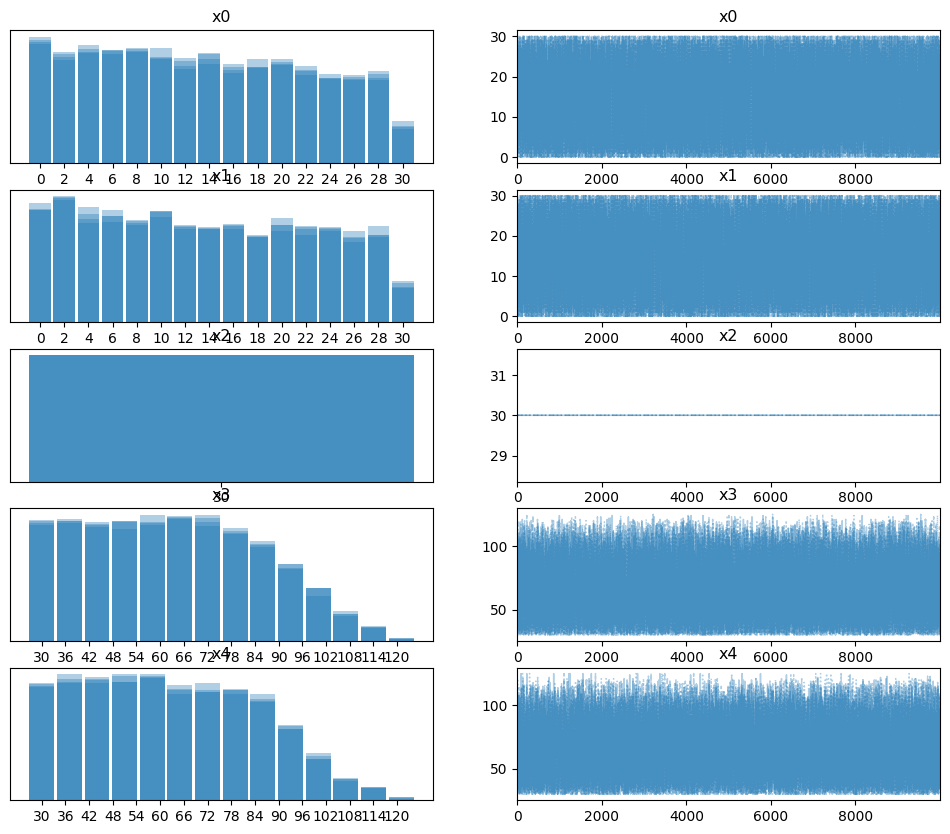

In [19]:
# Trace plot
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('spur_trace_plot.pdf');

In [20]:
# Diagnosis
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,14.027,8.865,0.0,28.0,0.044,0.032,39835.0,40248.0,1.0
x1,14.120,8.963,0.0,28.0,0.045,0.032,40693.0,38892.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,0.000,40000.0,40000.0,NaN
x3,66.150,22.152,30.0,102.0,0.111,0.078,39900.0,39428.0,1.0
x4,65.505,21.862,30.0,101.0,0.111,0.078,38877.0,38807.0,1.0
